In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predictive-analytics-for-customer-churn-dataset/data_descriptions.csv
/kaggle/input/predictive-analytics-for-customer-churn-dataset/train.csv
/kaggle/input/predictive-analytics-for-customer-churn-dataset/test.csv


In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

import os

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
if tf.test.is_gpu_available():
    # Imprime información sobre la GPU
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    print(tf.test.gpu_device_name())
else:
    print("No se ha encontrado una GPU disponible.")

/device:GPU:0


In [5]:
df = pd.read_csv("/kaggle/input/predictive-analytics-for-customer-churn-dataset/train.csv")

In [6]:
df

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243782,77,9.639902,742.272460,Basic,Mailed check,No,Movies,No,Computer,13.502729,...,47,Sci-Fi,3.697451,1,Male,8,Yes,No,FBZ38J108Z,0
243783,117,13.049257,1526.763053,Premium,Credit card,No,TV Shows,Yes,TV,24.963291,...,35,Comedy,1.449742,4,Male,20,No,No,W4AO1Y6NAI,0
243784,113,14.514569,1640.146267,Premium,Credit card,Yes,TV Shows,No,TV,10.628728,...,44,Action,4.012217,6,Male,13,Yes,Yes,0H3SWWI7IU,0
243785,7,18.140555,126.983887,Premium,Bank transfer,Yes,TV Shows,No,TV,30.466782,...,36,Fantasy,2.135789,7,Female,5,No,Yes,63SJ44RT4A,0


# Preprocessing

In [7]:
binary_columns = ['PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled']
df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})

In [8]:
cat_columns = df[['PaymentMethod', 'SubscriptionType', 'ContentType', 'DeviceRegistered', 'GenrePreference']]

In [9]:
encoded_dfs = []
for column in cat_columns:
    encoded_df = pd.get_dummies(df[column], prefix=column, dtype=int)
    encoded_dfs.append(encoded_df)

df = pd.concat([df] + encoded_dfs, axis=1)

In [10]:
df = df.drop(cat_columns, axis=1)

In [11]:
num_columns = df[['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']]

In [12]:
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()

X_train[num_columns.columns] = scaler.fit_transform(X_train[num_columns.columns])

X_val[num_columns.columns] = scaler.transform(X_val[num_columns.columns])

# Random Forest

In [15]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

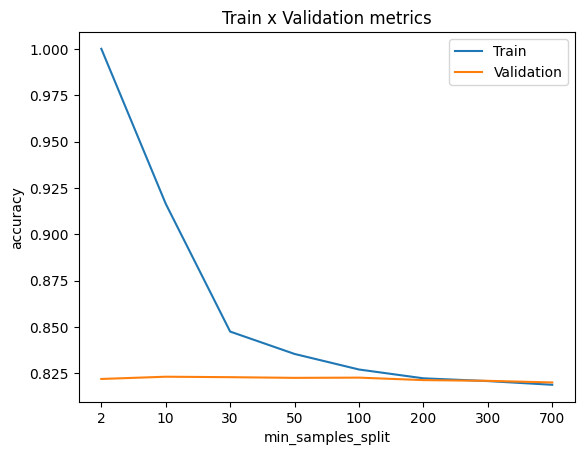

In [16]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 32).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

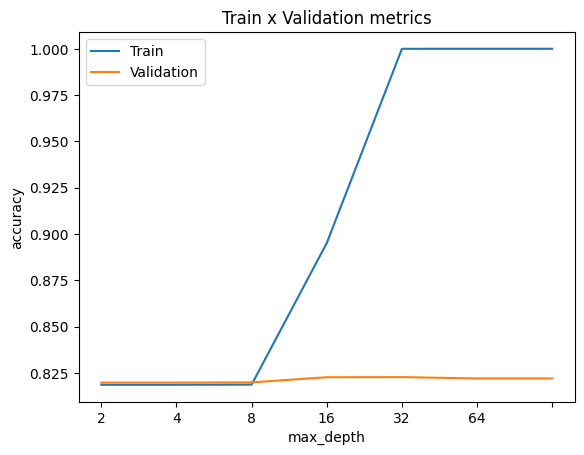

In [17]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 32).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

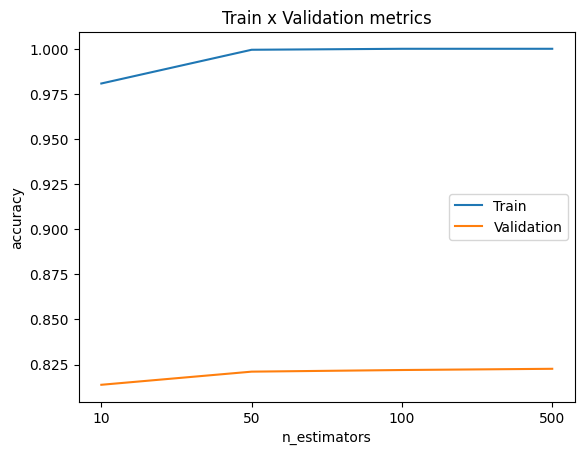

In [18]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 32).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [19]:
random_forest_model = RandomForestClassifier(n_estimators = 50,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [20]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8658
Metrics test:
	Accuracy score: 0.8224


# XGBoost

In [21]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [22]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = 32)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.64972
[1]	validation_0-logloss:0.61420
[2]	validation_0-logloss:0.58478
[3]	validation_0-logloss:0.56040
[4]	validation_0-logloss:0.53992
[5]	validation_0-logloss:0.52261
[6]	validation_0-logloss:0.50801
[7]	validation_0-logloss:0.49557
[8]	validation_0-logloss:0.48501
[9]	validation_0-logloss:0.47604
[10]	validation_0-logloss:0.46838
[11]	validation_0-logloss:0.46178
[12]	validation_0-logloss:0.45613
[13]	validation_0-logloss:0.45122
[14]	validation_0-logloss:0.44705
[15]	validation_0-logloss:0.44348
[16]	validation_0-logloss:0.44043
[17]	validation_0-logloss:0.43782
[18]	validation_0-logloss:0.43548
[19]	validation_0-logloss:0.43350
[20]	validation_0-logloss:0.43177
[21]	validation_0-logloss:0.43026
[22]	validation_0-logloss:0.42898
[23]	validation_0-logloss:0.42781
[24]	validation_0-logloss:0.42686
[25]	validation_0-logloss:0.42603
[26]	validation_0-logloss:0.42527
[27]	validation_0-logloss:0.42453
[28]	validation_0-logloss:0.42389
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=32, ...)

In [23]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8272
Metrics test:
	Accuracy score: 0.8242
